In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymongo as pm
import pprint
from enum import Enum
from datetime import datetime, timedelta
import geojson
import seaborn as sb

pd.set_option("display.max_columns", None)
mpl.rcParams["figure.dpi"] = 100

In [40]:

client = pm.MongoClient('bigdatadb.polito.it',                     
                        ssl=True,                     
                        authSource = 'carsharing',                     
                        username = 'ictts',                     
                        password ='Ict4SM22!',                     
                        tlsAllowInvalidCertificates=True) 
db = client['carsharing'] 

#Choose the DB to use 
Ictts_enj_p_booking = db['ictts_enjoy_PermanentBookings']
Ictts_p_booking = db['ictts_PermanentBookings']

#date starts from 01/01/2018 to 31/01/2018 1514761200 - 1517353200
start_unix_time = datetime.strptime("01/12/2017", "%d/%m/%Y").timestamp()
end_unix_time = datetime.strptime("31/01/2018", "%d/%m/%Y").timestamp()

with open("TorinoZonescol.geojson") as f:
    gj = geojson.load( f )


rental_args = [
{" Weekends-Afternoon": (False , False )},
{" Weekends-Morning": (False , True )},
{" Weekdays-Afternoon": (True , False )},
{" Weekdays-Morning": (True , True )}
]


In [ ]:
#weekday - days 2-6 -morning 7-11 - afternoon 12-18
#weekend - days 1,7 -morning 7-12 - afternoon 13-18
def weekday_piper(start_hour,end_hour,origin_zone,destination_zone):
  return [
    { "$project":
     {
       "hour":{"$hour":"$init_date"},
       "day":{"$dayOfWeek":"$init_date"},
       "init_loc":1,
       "final_loc":1,
       "init_time":1
       }
    },
    { "$match": {
      "day":{"$gte":2,"$lte":6},
      "hour":{"$gte":start_hour,"$lte":end_hour},
      "init_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":origin_zone}}},
      "final_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":destination_zone}}}}
    },
    { "$count":"tot"}
  ]

def weekend_piper(start_hour,end_hour,origin_zone,destination_zone):
  return [
    { "$project":
     {
       "hour":{"$hour":"$init_date"},
       "day":{"$dayOfWeek":"$init_date"},
       "init_loc":1,
       "final_loc":1,
       "init_time":1
       }
    },
    { "$match":{
      "day":1 and 7,
      "hour":{"$gte":start_hour,"$lte":end_hour},
      "init_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":origin_zone}}},
      "final_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":destination_zone}}}}},
    {"$count": "tot"}
  ]

In [ ]:
def extract_od_matrix(start_hour =7 , end_hour =11, pipeline=[{}]):
  OD_matrix = [([0]*23) for i in range(23) ]
  for i in range(23) :
    orig_zone = gj["features"][i]["geometry"]["coordinates"]
    for j in range(23) :
      dest_zone = gj["features"][j]["geometry"]["coordinates"]
      pipeline = pipeline(start_hour,end_hour,orig_zone,dest_zone)
      result = list ( Ictts_enj_p_booking.aggregate(pipeline))
      if( len(result ) > 0):
        OD_matrix[i][j] = result[0]["tot"]
      else :
        OD_matrix[i][j] = 0
  output_df = pd.DataFrame ( OD_matrix )
  output_df.columns =["Q"+f"{i:03d}" for i in range(1, 24) ]
  output_df['index'] =["Q"+f"{i:03d}" for i in range(1, 24) ]
  output_df = output_df.set_index('index', drop = True ).rename_axis( None )
  return output_df

In [ ]:
booking_OD_matrix = []
weekday_morning = extract_od_matrix(7,11,weekday_piper)
weekday_afternoon = extract_od_matrix(12,18,weekday_piper)
weekend_morning = extract_od_matrix(7,12,weekend_piper)
weekend_afternoon = extract_od_matrix(13,18,weekend_piper)

booking_OD_matrix.append(weekday_morning)
booking_OD_matrix.append(weekday_afternoon)
booking_OD_matrix.append(weekend_morning)
booking_OD_matrix.append(weekend_afternoon)

weekday_morning.to_csv("weekday_morning.csv")
weekday_afternoon.to_csv("weekday_afternoon.csv")
weekend_morning.to_csv("weekend_morning.csv")
weekend_afternoon.to_csv("weekend_afternoon.csv")

OD_Matrix_01 is saved !
OD_Matrix_02 is saved !
OD_Matrix_03 is saved !
OD_Matrix_04 is saved !
IMQ_OD_Matrix_01 is saved !
IMQ_OD_Matrix_02 is saved !
IMQ_OD_Matrix_03 is saved !
IMQ_OD_Matrix_04 is saved !
IMQ_OD_Matrix_05 is saved !
IMQ_OD_Matrix_06 is saved !
IMQ_OD_Matrix_07 is saved !
IMQ_OD_Matrix_08 is saved !
IMQ_OD_Matrix_09 is saved !
IMQ_OD_Matrix_10 is saved !


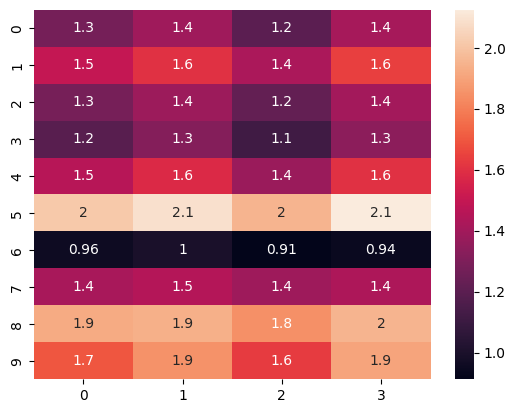

In [41]:
# Data Extraction from IMQ dataset
imq = pd.read_csv("spostamentiTorino.csv")
imq.head()

def create_pivot_table_with_filters(data , filters ):
  conditions = []
 # Apply filters
  for column, condition in filters.items():
    conditions.append( condition )
  filtered_data = data[conditions[0]]
 # Create pivot table using filtered data
  pivot_table = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
  return pivot_table

filters = [
 {
  'SESSO':imq['SESSO'] == 1, # all male
  },
  {
  'SESSO':imq['SESSO'] == 2, # all female
  },
  {
  'FASCIA_ETA':imq["FASCIA_ETA"]== 1 # from 11 to 19 years old
  },
  {
  'FASCIA_ETA':imq["FASCIA_ETA"] == 2 # from 20 to 49 years old
  },
  {
  'FASCIA_ETA':imq["FASCIA_ETA"] == 3 # from 50 to 64 years old
  },
  {
  'FASCIA_ETA':imq["FASCIA_ETA"] == 4 # 65+ years old
  },
  {
  'SCOPO':imq["SCOPO"] == 1 # aim : go to work
  },
  {
  'SCOPO':imq["SCOPO"] == 3 # aim : study
  },
  {
  'SCOPO':imq["SCOPO"] == 4 # aim : shopping
  },
  {
  'SCOPO':imq["SCOPO"] == 8 # aim : going back home
  },
]


IMQ_OD_matrices = []
for i, f in enumerate( filters ):
  df = create_pivot_table_with_filters(imq , f)
  df.to_csv("IMQ_OD_Matrix_"+f"{i+1}"+".csv")
  print("IMQ_OD_Matrix_"+f"{i+1:02d}"+" is saved !")
  IMQ_OD_matrices.append(df)


# • Comparison between the OD Matrices
def L2_distance( matrix1 , matrix2 ):
 # Ensure matrices have the same dimensions
 assert matrix1.shape == matrix2.shape , "Matrices must have the same dimensions"
 normalized_matrix1 = matrix1 / matrix1.sum( axis =1, keepdims = True )
 normalized_matrix2 = matrix2 / matrix2.sum( axis =1, keepdims = True )
 # Calculate the squared differences between corresponding cells
 squared_diff = np.square( normalized_matrix1 - normalized_matrix2 )
 # Sum the squared differences
 sum_squared_diff = np.sum( squared_diff )
 # Take the square root to obtain the L2 distance
 l2_distance = np.sqrt( sum_squared_diff )
 return l2_distance

distances = [([0]* len( booking_OD_matrix )) for i in range(len( IMQ_OD_matrices ))]

for i, imq in enumerate( IMQ_OD_matrices ):
  for j, rental in enumerate( booking_OD_matrix ):
    distance = L2_distance(imq.values , rental.values )
    distances[i][j] = distance

#  plotting the heatmap
# hm = sb.heatmap( data =np.array( distances ), annot = True )
#  displaying the plotted heatmap
# plt.show()
# Plotting the OD Matrices
    
def plot_matrix( od_matrix , title ):
 # Create meshgrid for x and y values
 x, y = np.meshgrid( range( od_matrix.shape[0]) , range( od_matrix.shape[1]) )
 # Create figure and 3D axes
 fig = plt.figure(dpi =300 , figsize =(12 , 12))
 ax = fig.add_subplot(111 , projection ='3d ')
 # Create surface plot
 ax.plot_surface(x, y, od_matrix , cmap =' viridis ')
 # Set labels and title
 ax.set_xlabel('Origin ')
 ax.set_ylabel(' Destination ')
 ax.set_zlabel('Flow ')
 ax.set_title( title )

 # Show the plot
 plt.show()

 for i, args in enumerate( rental_args ):
  title = list( rental_args[i].keys())[0]
  plot_matrix( booking_OD_matrix[i].values , title )

 for i, od_matrix in enumerate( IMQ_OD_matrices ):
  plot_matrix( IMQ_OD_matrices[i].values , " ")